### ML 데이터 준비

- data__데이터전처리통합.ipynb 아래 코드에서 담당 카테고리의 변경사항 있을시 수정해서 사용

In [7]:
# 라이브러리
import os
import json
import pandas as pd
import numpy as np
from pathlib import Path

# 환경설정
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 100)      # 행 전체 표시
pd.set_option('display.max_columns', None)  # 열 전체 표시
pd.set_option('display.width', None)        # 가로폭 자동 맞춤
pd.set_option('display.max_colwidth', None) # 셀 안의 텍스트 생략 방지
pd.set_option('display.float_format', '{:.6f}'.format)

# 경로 설정
ROOT_DIR = Path("").resolve().parent.parent

# 데이터 경로
DATA_DIR = ROOT_DIR / "data"
DATA_PATH = DATA_DIR / "analy_data.csv"
SAVE_FILE = "preprocessed_v1.csv"

# JSON 컬럼 관리 파일 로드
with open('columns.json', "r", encoding="utf-8") as f:
    columns_dict = json.load(f)

# 공통 함수 
def get_columns(*categories):
    """columns.json의 카테고리별 use=y 컬럼 추출"""
    selected = []
    for cat in categories:
        for col, meta in columns_dict[cat].items():
            if meta.get("use", "n") == "y": 
                selected.append(col)
    
    if "churn" not in selected:
        selected.append("churn")

    if "exmprs_no" not in selected:
        selected.append("exmprs_no")

    return selected

def rename_to_kor(df):
    """columns.json의 name으로 한글 컬럼명 매핑"""
    rename_map = {
        col: meta["name"]
        for cat in columns_dict.values()
        for col, meta in cat.items()
        if col in df.columns
    }
    return df.rename(columns=rename_map)

# 1. 기본정보 + 가구조사 
def preprocess_basic_house(data_path):
    cols = get_columns("기본정보", "가구조사")
    df = pd.read_csv(data_path, usecols=cols)

    # 'b' 문자 전처리
    if "exmprs_no" in df.columns:
        df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

    if "CTPRVN_CODE" in df.columns:
        df['CTPRVN_CODE'] = df['CTPRVN_CODE'].apply(lambda x: x.split("'")[1])
    
    if "SPOT_NO" in df.columns:
        df['SPOT_NO'] = df['SPOT_NO'].apply(lambda x: x.split("'")[1])
    
    if "sex" in df.columns:
        df['sex'] = df['sex'].apply(lambda x: 1 if x == 1 else 2).astype(str)

    # NaN 변경
    for col in ["fma_04z1", "nue_01z1", "fma_27z1", "fma_26z1"]:
        if col in df.columns:
            df.loc[df[col] >= 7, col] = np.nan

    for col in ["fma_13z1", "fma_14z1"]:
        if col in df.columns:
            df.loc[df[col] >= 77777, col] = np.nan

    for col in ["fma_24z2"]:
            if col in df.columns:
                df.loc[df[col] >= 77, col] = np.nan

    return df

# 2. 식생활 + 비만및체중조절 + 구강건강
def preprocess_diet_obesity_oral(data_path):
    cols = get_columns("식생활", "비만및체중조절", "구강건강")
    
    # 여기서 새 변수 2개 추가
    add_cols = ["oba_bmi", "oba_01z1"]
    cols = cols + [c for c in add_cols if c not in cols]  # 중복 방지
    
    df = pd.read_csv(data_path, usecols=cols)

    # 'b' 문자 전처리
    if "exmprs_no" in df.columns:
        df["exmprs_no"] = df["exmprs_no"].apply(lambda x: x.split("'")[1])

    # NaN 변경 (공통)
    for col in [
        "nua_01z2", "nuc_02z1", "nuc_03z1",
        "obb_02a1", "obb_02b1", "obb_02d1",
        "ora_01z1", "orb_01z1", "ord_01d2",
        "ord_05z1", "ord_01f3", "oba_bmi", "oba_01z1"  # ← 새로 추가됨
    ]:
        if col in df.columns:
            df.loc[df[col] >= 77, col] = np.nan

    # ore_03z2 처리
    for col in ["ore_03z2"]:
        if col in df.columns:
            df.loc[df[col] >= 77, col] = np.nan

    return df


# 3. 음주 + 신체활동
def preprocess_drink_physical(data_path):
    cols = get_columns("음주", "신체활동")
    df = pd.read_csv(data_path, usecols=cols)

    # 'b' 문자 전처리
    if "exmprs_no" in df.columns:
        df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

    # 값 변경
    if "drb_01z3" in df.columns:
        df["drb_01z3"] = df["drb_01z3"].replace(8, 1)

    if "drb_03z1" in df.columns:
        df["drb_03z1"] = df["drb_03z1"].replace(8, -1)

    # NaN 변경 
    for col in ["drb_01z3", "drb_03z1", "drg_01z3", "pha_11z1", "drb_04z1", "drb_05z1"]:
        if col in df.columns:
            df.loc[df[col] >= 7, col] = np.nan

    for col in ["pha_04z1", "pha_07z1", "phb_01z1"]:
            if col in df.columns:
                df.loc[df[col] >= 77, col] = np.nan

    return df

# 4. 정신건강 + 보건이용
def preprocess_mental_health(data_path):
    cols = get_columns("정신건강", "보건이용")
    df = pd.read_csv(data_path, usecols=cols)

    # 'b' 문자 전처리
    if "exmprs_no" in df.columns:
        df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

    # NaN 변경 
    for col in ["mta_01z1", "mta_02z1", "mtc_08z1", "mtc_12c1", "mtc_12h1", "mtj_05z2", "mtj_10z1", "mtj_11z1"]:
        if col in df.columns:
            df.loc[df[col] >= 7, col] = np.nan

    for col in ["edit_mtc_03z1"]:
            if col in df.columns:
                df.loc[df[col] >= 77, col] = np.nan

    return df

# 5. 건강행태 + 교육및경제활동
def preprocess_behavior_education(data_path):
    cols = get_columns("건강행태", "교육및경제활동")
    df = pd.read_csv(data_path, usecols=cols)

    # 'b' 문자 전처리
    if "exmprs_no" in df.columns:
        df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

    # NaN 변경
    for col in ["smf_01z1", "sma_01z1", "sma_03z2", "smb_09z1", "sma_36z1", "sma_37z1", "sma_08z1", "sma_12z2"\
                "smd_02z3", "smd_01z3", "smc_08z2", "smc_09z2", "smc_10z2", "sob_02z1", "soa_01z1", "soa_07z1", "sod_02z3"]:
        if col in df.columns:
            df.loc[df[col] >= 7, col] = np.nan

    for col in ["smb_02z1", "smb_05z1", "sma_11z2", "sob_01z1", "soa_06z2", "smb_12z1"]:
            if col in df.columns:
                df.loc[df[col] >= 77, col] = np.nan

    for col in ["smb_13z1", "smb_03z1", "smb_04z1", "smb_06z1", "smb_11z1"]:
            if col in df.columns:
                df.loc[df[col] >= 777, col] = np.nan
    return df

df_basic = preprocess_basic_house(DATA_PATH)
df_health = preprocess_diet_obesity_oral(DATA_PATH)
df_drink = preprocess_drink_physical(DATA_PATH)
df_mental = preprocess_mental_health(DATA_PATH)
df_behavior = preprocess_behavior_education(DATA_PATH)

dfs = [df_basic, df_health, df_drink, df_mental, df_behavior]
df_merge = dfs[0]
for temp in dfs[1:]:
    join_cols = [c for c in ["exmprs_no", "churn"] if c in df_merge.columns and c in temp.columns]
    if join_cols:
        df_merge = pd.merge(df_merge, temp, on=join_cols, how="outer")

print("컬럼 식별 완료된 데이터 크기:", df_merge.shape,'-2')
print(f"결측치 비율: (평균) {df_merge.isna().mean().mean() * 100:.2f}%")

#=========================
# 추가 전처리
#=========================
# doyeon
#=========================
# '월간 폭음 경험(남)', '월간 폭음 경험(여)' ['drb_04z1', 'drb_05z1'] -> '월간 폭음 경험' ['drb_binge_monthly'] 통합
df_merge['sex'] = df_merge['sex']
df_merge['drb_binge_monthly'] = np.where(df_merge['sex'] == 1, df_merge['drb_04z1'], df_merge['drb_05z1'])
df_merge.drop(['drb_04z1', 'drb_05z1'], axis=1, inplace=True)

# 값변경
df_merge['drb_binge_monthly'] = df_merge['drb_binge_monthly'].replace(8, -1)
df_merge.loc[df_merge['drb_binge_monthly'] >= 7, 'drb_binge_monthly'] = np.nan

# 범주형 칼럼 object형 변환
df_merge['dra_01z1'] = df_merge['dra_01z1'].astype('object')

#=========================
# soso
#=========================
# 연령대
df_merge['age_group'] = (df_merge['age'] // 10) * 10

# 1인가구
df_merge['is_single'] = np.where((df_merge['mbhld_co'] <= 1), 1, 0)

# 월간소득 기준 가구소득컬럼 통합
df_merge['fma_14z1_add'] = df_merge['fma_14z1'] 
df_merge['fma_14z1_add'] = round(df_merge['fma_14z1_add'].fillna(df_merge['fma_13z1'] / 12))
df_merge['fma_14z1_log'] = np.log1p(df_merge['fma_14z1_add'])

bins = [0, 50, 100, 200, 300, 400, 500, 600, float('inf')]
labels = [1, 2, 3, 4, 5, 6, 7, 8]
df_merge['fma_14z1_group'] = pd.cut(df_merge['fma_14z1_add'], bins=bins, labels=labels, right=False)
df_merge['fma_14z1_group'] = np.where(df_merge['fma_14z1_group'].isna(), df_merge['fma_24z2'].astype(float), df_merge['fma_14z1_group'])

# 치매가족여부
def get_dementia_case(row):
    if row['fma_27z1'] == 1 and row['fma_26z1'] == 1:
        return 1 # 치매가족 있음 + 같이 거주
    elif row['fma_27z1'] == 1 and row['fma_26z1'] == 2:
        return 2 # 치매가족 있음 + 비거주
    elif row['fma_27z1'] == 2:
        return 3 # 치매가족 없음
    else:
        return np.nan
    


df_merge['fma_dementia_case'] = df_merge.apply(get_dementia_case, axis=1)
df_merge.drop(['fma_13z1', 'fma_14z1','fma_27z1','fma_26z1'], axis=1, inplace=True)
print("추가 전처리 후 데이터 크기:", df_merge.shape ,'-2')
print("exmprs_no, wt_p 필요시 활용하기 위해 포함해놓음, 제외하고 사용")

컬럼 식별 완료된 데이터 크기: (89822, 79) -2
결측치 비율: (평균) 22.74%
추가 전처리 후 데이터 크기: (89822, 80) -2
exmprs_no, wt_p 필요시 활용하기 위해 포함해놓음, 제외하고 사용


In [ ]:
# # 라이브러리
# import os
# import json
# import pandas as pd
# import numpy as np
# from pathlib import Path

# # 환경설정
# import warnings
# warnings.filterwarnings('ignore')
# pd.set_option('display.max_rows', 100)      # 행 전체 표시
# pd.set_option('display.max_columns', None)  # 열 전체 표시
# pd.set_option('display.width', None)        # 가로폭 자동 맞춤
# pd.set_option('display.max_colwidth', None) # 셀 안의 텍스트 생략 방지
# pd.set_option('display.float_format', '{:.6f}'.format)

# # 경로 설정
# ROOT_DIR = Path("").resolve().parent.parent

# # 데이터 경로
# DATA_DIR = ROOT_DIR / "data"
# DATA_PATH = DATA_DIR / "analy_data.csv"
# SAVE_FILE = "preprocessed_v1.csv"

# # JSON 컬럼 관리 파일 로드
# with open('columns.json', "r", encoding="utf-8") as f:
#     columns_dict = json.load(f)

# # 공통 함수 
# def get_columns(*categories):
#     """columns.json의 카테고리별 use=y 컬럼 추출"""
#     selected = []
#     for cat in categories:
#         for col, meta in columns_dict[cat].items():
#             if meta.get("use", "n") == "y": 
#                 selected.append(col)
    
#     if "churn" not in selected:
#         selected.append("churn")

#     if "exmprs_no" not in selected:
#         selected.append("exmprs_no")

#     return selected

# def rename_to_kor(df):
#     """columns.json의 name으로 한글 컬럼명 매핑"""
#     rename_map = {
#         col: meta["name"]
#         for cat in columns_dict.values()
#         for col, meta in cat.items()
#         if col in df.columns
#     }
#     return df.rename(columns=rename_map)

# # 1. 기본정보 + 가구조사 
# def preprocess_basic_house(data_path):
#     cols = get_columns("기본정보", "가구조사")
#     df = pd.read_csv(data_path, usecols=cols)

#     # 'b' 문자 전처리
#     if "exmprs_no" in df.columns:
#         df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

#     if "CTPRVN_CODE" in df.columns:
#         df['CTPRVN_CODE'] = df['CTPRVN_CODE'].apply(lambda x: x.split("'")[1])
    
#     if "SPOT_NO" in df.columns:
#         df['SPOT_NO'] = df['SPOT_NO'].apply(lambda x: x.split("'")[1])
    
#     if "sex" in df.columns:
#         df['sex'] = df['sex'].apply(lambda x: 1 if x == 1 else 2).astype(str)

#     # NaN 변경
#     for col in ["fma_04z1", "nue_01z1", "fma_27z1", "fma_26z1"]:
#         if col in df.columns:
#             df.loc[df[col] >= 7, col] = np.nan

#     for col in ["fma_13z1", "fma_14z1"]:
#         if col in df.columns:
#             df.loc[df[col] >= 77777, col] = np.nan

#     for col in ["fma_24z2"]:
#             if col in df.columns:
#                 df.loc[df[col] >= 77, col] = np.nan

#     return df

# # 2. 식생활 + 비만및체중조절 + 구강건강
# def preprocess_diet_obesity_oral(data_path):
#     cols = get_columns("식생활", "비만및체중조절", "구강건강")
    
#     # 여기서 새 변수 2개 추가
#     add_cols = ["oba_bmi", "oba_01z1"]
#     cols = cols + [c for c in add_cols if c not in cols]  # 중복 방지
    
#     df = pd.read_csv(data_path, usecols=cols)

#     # 'b' 문자 전처리
#     if "exmprs_no" in df.columns:
#         df["exmprs_no"] = df["exmprs_no"].apply(lambda x: x.split("'")[1])

#     # NaN 변경 (공통)
#     for col in [
#         "nua_01z2", "nuc_02z1", "nuc_03z1",
#         "obb_02a1", "obb_02b1", "obb_02d1",
#         "ora_01z1", "orb_01z1", "ord_01d2",
#         "ord_05z1", "ord_01f3", "oba_bmi", "oba_01z1"  # ← 새로 추가됨
#     ]:
#         if col in df.columns:
#             df.loc[df[col] >= 77, col] = np.nan

#     # ore_03z2 처리
#     for col in ["ore_03z2"]:
#         if col in df.columns:
#             df.loc[df[col] >= 77, col] = np.nan

#     return df


# # 3. 음주 + 신체활동
# def preprocess_drink_physical(data_path):
#     cols = get_columns("음주", "신체활동")
#     df = pd.read_csv(data_path, usecols=cols)

#     # 'b' 문자 전처리
#     if "exmprs_no" in df.columns:
#         df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

#     # 값 변경
#     if "drb_01z3" in df.columns:
#         df["drb_01z3"] = df["drb_01z3"].replace(8, 1)

#     if "drb_03z1" in df.columns:
#         df["drb_03z1"] = df["drb_03z1"].replace(8, -1)

#     # NaN 변경 
#     for col in ["drb_01z3", "drb_03z1", "drg_01z3", "pha_11z1", "drb_04z1", "drb_05z1"]:
#         if col in df.columns:
#             df.loc[df[col] >= 7, col] = np.nan

#     for col in ["pha_04z1", "pha_07z1", "phb_01z1"]:
#             if col in df.columns:
#                 df.loc[df[col] >= 77, col] = np.nan

#     return df

# # 4. 정신건강 + 보건이용
# def preprocess_mental_health(data_path):
#     cols = get_columns("정신건강", "보건이용")
#     df = pd.read_csv(data_path, usecols=cols)

#     # 'b' 문자 전처리
#     if "exmprs_no" in df.columns:
#         df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

#     # NaN 변경 
#     for col in ["mta_01z1", "mta_02z1", "mtc_08z1", "mtc_12c1", "mtc_12h1", "mtj_05z2", "mtj_10z1", "mtj_11z1"]:
#         if col in df.columns:
#             df.loc[df[col] >= 7, col] = np.nan

#     for col in ["edit_mtc_03z1"]:
#             if col in df.columns:
#                 df.loc[df[col] >= 77, col] = np.nan

#     return df

# # 5. 건강행태 + 교육및경제활동
# def preprocess_behavior_education(data_path):
#     cols = get_columns("건강행태", "교육및경제활동")
#     df = pd.read_csv(data_path, usecols=cols)

#     # 'b' 문자 전처리
#     if "exmprs_no" in df.columns:
#         df['exmprs_no'] = df['exmprs_no'].apply(lambda x: x.split("'")[1])

#     # NaN 변경
#     for col in ["smf_01z1", "sma_01z1", "sma_03z2", "smb_09z1", "sma_36z1", "sma_37z1", "sma_08z1", "sma_12z2"\
#                 "smd_02z3", "smd_01z3", "smc_08z2", "smc_09z2", "smc_10z2", "sob_02z1", "soa_01z1", "soa_07z1", "sod_02z3"]:
#         if col in df.columns:
#             df.loc[df[col] >= 7, col] = np.nan

#     for col in ["smb_02z1", "smb_05z1", "sma_11z2", "sob_01z1", "soa_06z2", "smb_12z1"]:
#             if col in df.columns:
#                 df.loc[df[col] >= 77, col] = np.nan

#     for col in ["smb_13z1", "smb_03z1", "smb_04z1", "smb_06z1", "smb_11z1"]:
#             if col in df.columns:
#                 df.loc[df[col] >= 777, col] = np.nan
#     return df

# df_basic = preprocess_basic_house(DATA_PATH)
# df_health = preprocess_diet_obesity_oral(DATA_PATH)
# df_drink = preprocess_drink_physical(DATA_PATH)
# df_mental = preprocess_mental_health(DATA_PATH)
# df_behavior = preprocess_behavior_education(DATA_PATH)

# dfs = [df_basic, df_health, df_drink, df_mental, df_behavior]
# df_merge = dfs[0]
# for temp in dfs[1:]:
#     join_cols = [c for c in ["exmprs_no", "churn"] if c in df_merge.columns and c in temp.columns]
#     if join_cols:
#         df_merge = pd.merge(df_merge, temp, on=join_cols, how="outer")

# print("컬럼 식별 완료된 데이터 크기:", df_merge.shape,'-2')
# print(f"결측치 비율: (평균) {df_merge.isna().mean().mean() * 100:.2f}%")

# #=========================
# # 추가 전처리
# #=========================
# # doyeon
# #=========================
# # '월간 폭음 경험(남)', '월간 폭음 경험(여)' ['drb_04z1', 'drb_05z1'] -> '월간 폭음 경험' ['drb_binge_monthly'] 통합
# df_merge['sex'] = df_merge['sex']
# df_merge['drb_binge_monthly'] = np.where(df_merge['sex'] == 1, df_merge['drb_04z1'], df_merge['drb_05z1'])
# df_merge.drop(['drb_04z1', 'drb_05z1'], axis=1, inplace=True)

# # 값변경
# df_merge['drb_binge_monthly'] = df_merge['drb_binge_monthly'].replace(8, -1)
# df_merge.loc[df_merge['drb_binge_monthly'] >= 7, 'drb_binge_monthly'] = np.nan

# # 범주형 칼럼 object형 변환
# df_merge['dra_01z1'] = df_merge['dra_01z1'].astype('object')

# #=========================
# # soso
# #=========================
# # 연령대
# df_merge['age_group'] = (df_merge['age'] // 10) * 10

# # 1인가구
# df_merge['is_single'] = np.where((df_merge['mbhld_co'] <= 1), 1, 0)

# # 월간소득 기준 가구소득컬럼 통합
# df_merge['fma_14z1_add'] = df_merge['fma_14z1'] 
# df_merge['fma_14z1_add'] = round(df_merge['fma_14z1_add'].fillna(df_merge['fma_13z1'] / 12))
# df_merge['fma_14z1_log'] = np.log1p(df_merge['fma_14z1_add'])

# bins = [0, 50, 100, 200, 300, 400, 500, 600, float('inf')]
# labels = [1, 2, 3, 4, 5, 6, 7, 8]
# df_merge['fma_14z1_group'] = pd.cut(df_merge['fma_14z1_add'], bins=bins, labels=labels, right=False)
# df_merge['fma_14z1_group'] = np.where(df_merge['fma_14z1_group'].isna(), df_merge['fma_24z2'].astype(float), df_merge['fma_14z1_group'])

# # 치매가족여부
# def get_dementia_case(row):
#     if row['fma_27z1'] == 1 and row['fma_26z1'] == 1:
#         return 1 # 치매가족 있음 + 같이 거주
#     elif row['fma_27z1'] == 1 and row['fma_26z1'] == 2:
#         return 2 # 치매가족 있음 + 비거주
#     elif row['fma_27z1'] == 2:
#         return 3 # 치매가족 없음
#     else:
#         return np.nan
    
# # =========================
# # 흡연유형 통합 (일반/권련형/액상형)  + 원핫 옵션
# # =========================
# # 참고: 각 변수 존재 여부를 확인하면서 안전하게 처리
# # - 일반담배 현재흡연: sma_03z2 (1=예)
# # - 권련형 전자담배 사용/현재: sma_36z1, sma_37z1 (1=예)
# # - 액상형 전자담배 사용/현재: sma_08z1, sma_12z2 (1=예)
# # - 보조지표(있으면 추가 반영): smb_13z1(권련 흡연량), sma_11z2(액상 빈도 등)

# def _yes(series):
#     """1=예 로 코딩된 이진 변수 안전 체크"""
#     if series is None:
#         return pd.Series(False, index=df_merge.index)
#     return (series == 1)

# # 존재하면 불러오고 없으면 None
# col = df_merge.columns
# sma_03z2 = df_merge['sma_03z2'] if 'sma_03z2' in col else None     # 일반담배 현재흡연
# sma_36z1 = df_merge['sma_36z1'] if 'sma_36z1' in col else None     # 권련 사용경험/여부
# sma_37z1 = df_merge['sma_37z1'] if 'sma_37z1' in col else None     # 권련 현재/패턴
# sma_08z1 = df_merge['sma_08z1'] if 'sma_08z1' in col else None     # 액상 사용여부
# sma_12z2 = df_merge['sma_12z2'] if 'sma_12z2' in col else None     # 액상 기타지표
# smb_13z1 = df_merge['smb_13z1'] if 'smb_13z1' in col else None     # 권련 흡연량(있으면 가중)
# sma_11z2 = df_merge['sma_11z2'] if 'sma_11z2' in col else None     # 액상 빈도(있으면 가중)

# # 타입 정리: 일부가 object일 수 있어 수치 변환
# for s in ['sma_03z2','sma_36z1','sma_37z1','sma_08z1','sma_12z2','smb_13z1','sma_11z2']:
#     if s in df_merge.columns:
#         df_merge[s] = pd.to_numeric(df_merge[s], errors='coerce')

# is_cig = _yes(sma_03z2)
# is_hnb = _yes(sma_36z1) | _yes(sma_37z1)
# is_liq = _yes(sma_08z1) | _yes(sma_12z2)

# # 가중치(선택): 보조지표가 있으면 해당 유형의 점수를 강화
# hnb_boost = (smb_13z1.fillna(0) > 0) if smb_13z1 is not None else False
# liq_boost = (sma_11z2.fillna(0) > 0) if sma_11z2 is not None else False

# # 점수 기반 대표유형 선택 (동시 사용자 처리)
# # 기본 점수: 일반=3, 권련=2, 액상=1  (+부스터 0.5)
# score_cig = is_cig.astype(float) * 3.0
# score_hnb = is_hnb.astype(float) * 2.0 + (0.5 * hnb_boost.astype(float))
# score_liq = is_liq.astype(float) * 1.0 + (0.5 * liq_boost.astype(float))

# # 대표유형 결정
# def _pick_type(a, b, c):
#     # a=일반, b=권련, c=액상
#     if (a==0) and (b==0) and (c==0):
#         return "비흡연자"
#     mx = max(a, b, c)
#     if mx == a:
#         return "일반담배"
#     elif mx == b:
#         return "권련형전자담배"
#     else:
#         return "액상형전자담배"

# df_merge['smoke_type'] = [
#     _pick_type(a, b, c)
#     for a, b, c in zip(score_cig, score_hnb, score_liq)
# ]

# # 복합흡연자 태그(분석용): 예) "일반담배+권련형"
# def _multi_tag(cig, hnb, liq):
#     tags = []
#     if cig: tags.append("일반담배")
#     if hnb: tags.append("권련형전자담배")
#     if liq: tags.append("액상형전자담배")
#     return "비흡연자" if len(tags)==0 else "+".join(tags)

# df_merge['smoke_multi'] = [
#     _multi_tag(c, h, l) for c, h, l in zip(is_cig, is_hnb, is_liq)
# ]

# # 원핫(선택): 바로 모델에 쓰고 싶으면 주석 해제
# # dummies = pd.get_dummies(df_merge['smoke_type'], prefix='smoke', dtype=int)
# # df_merge = pd.concat([df_merge, dummies], axis=1)

# print("흡연유형 통합 완료: smoke_type / smoke_multi 생성")

    


# df_merge['fma_dementia_case'] = df_merge.apply(get_dementia_case, axis=1)
# df_merge.drop(['fma_13z1', 'fma_14z1','fma_27z1','fma_26z1'], axis=1, inplace=True)
# print("추가 전처리 후 데이터 크기:", df_merge.shape ,'-2')
# print("exmprs_no, wt_p 필요시 활용하기 위해 포함해놓음, 제외하고 사용")

In [8]:
# 한글컬럼으로 확인할 시 사용
df_merge_kor = rename_to_kor(df_merge)

---

### 모델에 들어가는 피처 핸들링하고 테스트 해보기 (포맷 고정)

In [14]:
# 위 코드 실행 결과: df_merge
df = df_merge.copy()
df = df.drop(['exmprs_no','wt_p'], axis=1)
df.head()

,age,sex,CTPRVN_CODE,SPOT_NO,mbhld_co,reside_adult_co,fma_04z1,fma_24z2,nue_01z1,churn,nua_01z2,nuc_02z1,nuc_03z1,oba_bmi,oba_01z1,obb_01z1,obb_02a1,obb_02b1,obb_02d1,ora_01z1,orb_01z1,ord_01d2,ord_05z1,ord_01f3,ore_03z2,dra_01z1,drb_01z3,drb_03z1,drg_01z3,pha_04z1,pha_07z1,phb_01z1,pha_11z1,mta_01z1,mta_02z1,edit_mtc_03z1,mtc_08z1,mtc_12c1,mtc_12h1,mtj_05z2,mtj_10z1,mtj_11z1,smf_01z1,sma_01z1,sma_03z2,smb_01z1,smb_02z1,smb_03z1,smb_04z1,smb_05z1,smb_06z1,smb_09z1,sma_36z1,sma_37z1,smb_11z1,smb_12z1,smb_13z1,sma_08z1,sma_11z2,sma_12z2,smd_02z3,smd_01z3,smc_08z2,smc_09z2,smc_10z2,sob_01z1,sob_02z1,soa_01z1,soa_06z2,soa_07z1,sod_02z3,drb_binge_monthly,age_group,is_single,fma_14z1_add,fma_14z1_log,fma_14z1_group,fma_dementia_case
0,31.000000,1,11,00102,1.000000,1.000000,3.000000,NaN,1.000000,1,4.000000,2.000000,8.000000,25.800000,4.000000,1.000000,1.000000,2.000000,2.000000,3.000000,5.000000,1.000000,8.000000,1.000000,NaN,1.000000,5.000000,3.000000,1.000000,2.000000,2.000000,5.000000,3.000000,2.000000,2.000000,0.000000,NaN,4.000000,2.000000,NaN,NaN,NaN,1.000000,1.000000,3.000000,888.000000,NaN,NaN,2.000000,0.000000,1.000000,3.000000,2.000000,NaN,NaN,NaN,NaN,2.000000,NaN,3.000000,8.000000,NaN,2.000000,NaN,2.000000,7.000000,1.000000,1.000000,3.000000,2.000000,5.000000,NaN,30.000000,1,1000.000000,6.908755,8.000000,3.000000
1,37.000000,1,11,00102,3.000000,2.000000,3.000000,NaN,1.000000,0,2.000000,1.000000,1.000000,22.500000,3.000000,4.000000,8.000000,8.000000,8.000000,2.000000,5.000000,2.000000,1.000000,1.000000,NaN,1.000000,4.000000,4.000000,1.000000,3.000000,1.000000,7.000000,1.000000,4.000000,NaN,1.000000,NaN,1.000000,1.000000,NaN,NaN,NaN,1.000000,2.000000,1.000000,15.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,2.000000,NaN,3.000000,2.000000,4.000000,2.000000,NaN,2.000000,5.000000,1.000000,1.000000,4.000000,2.000000,1.000000,NaN,30.000000,0,300.000000,5.707110,5.000000,3.000000
2,36.000000,2,11,00102,3.000000,2.000000,3.000000,NaN,1.000000,1,4.000000,2.000000,8.000000,21.500000,4.000000,2.000000,2.000000,2.000000,2.000000,2.000000,5.000000,1.000000,8.000000,1.000000,NaN,1.000000,5.000000,4.000000,2.000000,0.000000,4.000000,7.000000,1.000000,2.000000,2.000000,1.000000,NaN,3.000000,1.000000,NaN,NaN,NaN,1.000000,2.000000,3.000000,888.000000,NaN,NaN,5.000000,0.000000,10.000000,3.000000,2.000000,NaN,NaN,NaN,NaN,2.000000,NaN,3.000000,8.000000,NaN,2.000000,NaN,2.000000,6.000000,1.000000,1.000000,4.000000,2.000000,1.000000,4.000000,30.000000,0,300.000000,5.707110,5.000000,3.000000
3,36.000000,1,11,00102,2.000000,2.000000,3.000000,NaN,1.000000,0,4.000000,1.000000,8.000000,29.700000,4.000000,1.000000,1.000000,2.000000,2.000000,4.000000,3.000000,2.000000,1.000000,1.000000,NaN,1.000000,4.000000,4.000000,1.000000,0.000000,3.000000,5.000000,1.000000,2.000000,2.000000,0.000000,NaN,1.000000,1.000000,NaN,NaN,NaN,1.000000,2.000000,1.000000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,2.000000,NaN,3.000000,2.000000,2.000000,2.000000,NaN,2.000000,7.000000,1.000000,1.000000,3.000000,2.000000,1.000000,NaN,30.000000,0,667.000000,6.504288,8.000000,3.000000
4,64.000000,1,11,00191,1.000000,1.000000,1.000000,NaN,4.000000,0,2.000000,2.000000,8.000000,17.700000,1.000000,3.000000,8.000000,8.000000,8.000000,2.000000,1.000000,1.000000,8.000000,1.000000,3.000000,1.000000,4.000000,5.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,22.000000,6.000000,4.000000,1.000000,1.000000,2.000000,2.000000,1.000000,2.000000,1.000000,10.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.000000,NaN,NaN,NaN,NaN,2.000000,NaN,3.000000,2.000000,4.000000,2.000000,NaN,3.000000,3.000000,3.000000,2.000000,NaN,NaN,5.000000,NaN,60.000000,1,50.000000,3.931826,2.000000,3.000000


In [10]:
from sklearn.model_selection import train_test_split

# 0) 복사
df = df_merge.copy()

# 1) 드랍 후보 (흡연/가중치/식별자)
drop_cols = [
    "exmprs_no","wt_p","sma_36z1","sma_37z1", 
    "smf_01z1","sma_01z1","smb_03z1","sma_08z1", 
    "smb_04z1","smb_06z1","smb_09z1","sma_12z2", 
    "smb_11z1","smb_12z1","sma_03z2","smb_13z1","sma_11z2",
    "smd_02z3","smb_01z1","smb_02z1","smb_05z1","smd_01z3","smc_09z2"]
# smc_08z2 smc_10z2 sma_03z2 sma_36z1 sma_37z1 sma_08z1 sma_12z2 smb_13z1 sma_11z2
 

# 2) 실제 존재/미존재 분리
present_cols = [c for c in drop_cols if c in df.columns]
missing_cols = [c for c in drop_cols if c not in df.columns]

# 3) 드랍 (있는 컬럼만)
df = df.drop(columns=present_cols)

print(f" 드랍한 컬럼: {present_cols}")
if missing_cols:
    print(f" 데이터프레임에 없어서 못 지운 컬럼: {missing_cols}")

# 4) 타깃/피처 분리 (churn 존재 확인)
if "churn" not in df.columns:
    raise KeyError(" 'churn' 컬럼이 없습니다. 타깃 컬럼명을 확인하세요.")

y = df["churn"].astype(int)
X = df.drop(columns=["churn"])

# 5) 층화 8:2 분할
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=2, stratify=y
)

print("Train:", X_train.shape, " Test:", X_test.shape)


 드랍한 컬럼: ['exmprs_no', 'wt_p', 'sma_36z1', 'sma_37z1', 'smf_01z1', 'sma_01z1', 'smb_03z1', 'sma_08z1', 'smb_04z1', 'smb_06z1', 'smb_09z1', 'sma_12z2', 'smb_11z1', 'smb_12z1', 'sma_03z2', 'smb_13z1', 'sma_11z2', 'smd_02z3', 'smb_01z1', 'smb_02z1', 'smb_05z1', 'smd_01z3', 'smc_09z2']
Train: (71857, 56)  Test: (17965, 56)


In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns

# from sklearn.compose import ColumnTransformer, make_column_selector as selector
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.impute import SimpleImputer
# from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
# from sklearn.metrics import (
#     accuracy_score, confusion_matrix, classification_report,
#     average_precision_score, roc_auc_score,
#     precision_recall_curve, roc_curve, f1_score
# )
# from xgboost import XGBClassifier
# from xgboost.callback import EarlyStopping
# from scipy.stats import randint, uniform


# # =========================
# # 0) 공통 전처리 파이프라인
# # =========================
# num_sel = selector(dtype_include=np.number)
# cat_sel = selector(dtype_include=['object','category'])

# preprocess = ColumnTransformer([
#     ("num", Pipeline([
#         ("imp", SimpleImputer(strategy="median"))
#     ]), num_sel),
#     ("cat", Pipeline([
#         ("imp", SimpleImputer(strategy="most_frequent")),
#         ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
#     ]), cat_sel)
# ])


# # =========================
# # 1) 클래스 불균형 자동 보정
# # =========================
# pos_ratio = y_train.mean()  # y=1 비율
# neg = (y_train == 0).sum()
# pos = (y_train == 1).sum()
# scale_pos_weight = max(1.0, neg / max(1, pos))  # 안전하게


# # =========================
# # 2) 베이스 모델 (콜백 EarlyStopping)
# # =========================
# base_model = XGBClassifier(
#     n_estimators=300,              # 조기종료로 자동 조절
#     tree_method="hist",
#     eval_metric="aucpr",
#     random_state=42,
#     n_jobs=-1,
#     # 불균형 보정
#     scale_pos_weight=scale_pos_weight
# )

# pipe = Pipeline([
#     ("pre", preprocess),
#     ("model", base_model)
# ])


# # =========================
# # 3) (라이트) 하이퍼파라미터: 권장 기본값 + ES만 사용
# #    - RandomizedSearchCV 제거
# # =========================
# from sklearn.model_selection import train_test_split
# from sklearn.base import clone
# from xgboost import XGBClassifier
# from xgboost.callback import EarlyStopping

# # 3-1) 훈련 내부에서 ES용 검증셋 10% 분리
# X_tr, X_es, y_tr, y_es = train_test_split(
#     X_train, y_train, test_size=0.10, stratify=y_train, random_state=42
# )

# # 3-2) 전처리 파이프라인을 "훈련분할(X_tr)"로 미리 맞춘 뒤,
# #      같은 인코딩/차원으로 ES 셋(X_es)을 변환해 모델 eval_set에 넣는다
# #      (전처리에 ES를 'fit'하면 누수/차원불일치 위험)
# pre_es = clone(preprocess).fit(X_tr, y_tr)
# X_es_tf = pre_es.transform(X_es)

# # 3-3) XGBoost 기본 파라미터(경험적 강건값)
# #      - EarlyStopping이 n_estimators를 자동으로 최적 지점으로 잘라줌
# best_model = XGBClassifier(
#     n_estimators=600,          # 넉넉히 주고 ES로 조기정지
#     learning_rate=0.07,       # 보수적 LR (안정)
#     max_depth=6,              # 과적합/과소적합 균형
#     min_child_weight=3,       # 노이즈 완화
#     subsample=0.8,            # 샘플 서브샘플링
#     colsample_bytree=0.8,     # 특성 서브샘플링
#     gamma=0.0,                # 필요시 0~2로 올려 규제 강화
#     reg_alpha=0.0,            # L1
#     reg_lambda=1.0,           # L2
#     tree_method="hist",
#     eval_metric="aucpr",
#     random_state=42,
#     n_jobs=-1,
#     scale_pos_weight=scale_pos_weight  # 불균형 보정
# )

# final_pipe = Pipeline([
#     ("pre", preprocess),
#     ("model", best_model)
# ])

# # 3-4) 조기종료 콜백 (XGBoost 3.x)
# es = EarlyStopping(
#     rounds=80,          # 개선 없으면 80라운드 후 정지 (조금 더 빠르게 하고 싶으면 50)
#     save_best=True,     # 최고 성능 시점으로 롤백
#     data_name="validation_0",
#     metric_name="aucpr"
# )

# # 3-5) 학습 (eval_set에는 "훈련기반으로 변환된" ES셋을 넣는다)
# final_pipe.fit(
#     X_tr, y_tr,
#     model__eval_set=[(X_es_tf, y_es)],
#     model__callbacks=[es]
# )

# # >>> 이후 섹션 6)~7) (평가/시각화)는 기존 코드 그대로 사용 <<<

# # =========================
# # 6) 테스트셋 평가 (@0.5 + 임곗값 최적화)
# # =========================
# y_proba = final_pipe.predict_proba(X_test)[:, 1]
# y_pred_05 = (y_proba >= 0.5).astype(int)

# print("\n==================== 결과 (@0.5 고정) ====================")
# print(f"Accuracy : {accuracy_score(y_test, y_pred_05):.4f}")
# print(f"PR-AUC   : {average_precision_score(y_test, y_proba):.4f}")
# print(f"ROC-AUC  : {roc_auc_score(y_test, y_proba):.4f}")
# print("Confusion Matrix")
# print(confusion_matrix(y_test, y_pred_05))
# print("\nClassification Report")
# print(classification_report(y_test, y_pred_05, digits=4))

# # ---- 임곗값 최적화 (F1 최대) ----
# prec, rec, ths = precision_recall_curve(y_test, y_proba)
# f1s = 2 * (prec * rec) / (prec + rec + 1e-12)
# best_idx = int(np.argmax(f1s))
# best_th = ths[max(0, best_idx-1)] if best_idx >= 1 else 0.5  # 안전 처리
# y_pred_best = (y_proba >= best_th).astype(int)

# print("\n================ 결과 (임곗값 최적화: 최대 F1) ================")
# print(f"Best Threshold : {best_th:.4f}")
# print(f"Accuracy       : {accuracy_score(y_test, y_pred_best):.4f}")
# print(f"F1 (best)      : {f1_score(y_test, y_pred_best):.4f}")
# print(f"PR-AUC         : {average_precision_score(y_test, y_proba):.4f}")
# print(f"ROC-AUC        : {roc_auc_score(y_test, y_proba):.4f}")
# print("Confusion Matrix (best-th)")
# print(confusion_matrix(y_test, y_pred_best))
# print("\nClassification Report (best-th)")
# print(classification_report(y_test, y_pred_best, digits=4))


# # =========================
# # 7) 시각화 (혼동행렬 / PR / ROC)
# # =========================
# plt.figure(figsize=(5,4.5))
# sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt="d", cmap="Blues")
# plt.title("Confusion Matrix (best threshold)")
# plt.xlabel("Predicted"); plt.ylabel("True")
# plt.tight_layout()
# plt.show()

# # PR Curve
# plt.figure(figsize=(5,4))
# plt.plot(rec, prec, label=f"PR Curve (AP={average_precision_score(y_test, y_proba):.3f})")
# plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision-Recall Curve")
# plt.legend(); plt.tight_layout(); plt.show()

# # ROC Curve
# fpr, tpr, _ = roc_curve(y_test, y_proba)
# plt.figure(figsize=(5,4))
# plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc_score(y_test, y_proba):.3f})")
# plt.plot([0,1],[0,1],'--')
# plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title("ROC Curve")
# plt.legend(); plt.tight_layout(); plt.show()


In [15]:
# =========================
# XGB 2-Stage Pipeline
#   - Stage1: is_smoker (현재흡연자 여부) 분류
#   - Stage2: 흡연자 subset에서 churn 예측
# =========================
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit, train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    average_precision_score, roc_auc_score, precision_recall_curve, f1_score
)
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")

# ---------------------------------
# 0) 준비: 흡연 관련 컬럼 정의(네가 준 리스트 그대로 사용)
# ---------------------------------
smoking_cols = [
    "exmprs_no","wt_p","sma_36z1","sma_37z1",
    "smf_01z1","sma_01z1","smb_03z1","sma_08z1",
    "smb_04z1","smb_06z1","smb_09z1","sma_12z2",
    "smb_11z1","smb_12z1","sma_03z2","smb_13z1","sma_11z2",
    "smd_02z3","smb_01z1","smb_02z1","smb_05z1","smd_01z3","smc_09z2"
]

target_col = "churn"   # (가정) 1=금연(이탈), 0=흡연(잔존)

# ---------------------------------
# 1) is_smoker 생성 (있으면 사용 / 없으면 유추)
#    - 유추 로직: 주어진 흡연컬럼 중 하나라도 값이 있으면(비결측) is_smoker=1
# ---------------------------------
df = df_merge.copy()

if "is_smoker" not in df.columns:
    # 안전한 유추: smoking_cols 중 실제 존재하는 컬럼만 사용
    use_cols = [c for c in smoking_cols if c in df.columns]
    if len(use_cols) == 0:
        raise ValueError("흡연 관련 컬럼이 데이터프레임에 없습니다. is_smoker를 만들 수 없어요.")
    df["is_smoker"] = (df[use_cols].notna().sum(axis=1) > 0).astype(int)

# ---------------------------------
# 2) Train/Test 분리 (Group by exmprs_no)
# ---------------------------------
if "exmprs_no" not in df.columns:
    raise ValueError("exmprs_no 컬럼이 없어 그룹 분할을 할 수 없습니다.")

groups = df["exmprs_no"].astype(str).values
idx = np.arange(len(df))
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, test_idx = next(gss.split(idx, groups=groups))

train_df = df.iloc[train_idx].reset_index(drop=True)
test_df  = df.iloc[test_idx].reset_index(drop=True)

# ---------------------------------
# 3) 공통 전처리 파이프라인
#    - 수치: median impute
#    - 범주: most_frequent + OneHot
# ---------------------------------
num_sel = selector(dtype_include=np.number)
cat_sel = selector(dtype_include=["object", "category"])

preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
    ]), num_sel),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), cat_sel)
])

# ---------------------------------
# 4) Stage1: is_smoker 분류
#    - 입력: 전체 공통 피처 (흡연 컬럼, 타깃, 식별자는 제외)
# ---------------------------------
drop_for_stage1 = set([target_col, "is_smoker", "exmprs_no", "wt_p"])
drop_for_stage1.update([c for c in smoking_cols if c in df.columns])

features_stage1 = [c for c in df.columns if c not in drop_for_stage1]

X1_train = train_df[features_stage1]
y1_train = train_df["is_smoker"]
X1_test  = test_df[features_stage1]
y1_test  = test_df["is_smoker"]

model_s1 = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.06,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist",
    eval_metric="aucpr",
    random_state=42,
    n_jobs=-1
)

pipe_s1 = Pipeline([
    ("pre", preprocess),
    ("model", model_s1)
])

pipe_s1.fit(X1_train, y1_train)

# Stage1 평가
p1_test = pipe_s1.predict_proba(X1_test)[:, 1]
y1_pred = (p1_test >= 0.5).astype(int)

print("\n==== [Stage 1] is_smoker 분류 성능 ====")
print(f"Accuracy:  {accuracy_score(y1_test, y1_pred):.4f}")
print(f"PR-AUC:    {average_precision_score(y1_test, p1_test):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y1_test, p1_test):.4f}")
print("\n[Confusion Matrix]\n", confusion_matrix(y1_test, y1_pred))
print("\n[Classification Report]\n", classification_report(y1_test, y1_pred, digits=4))

# 임계값 최적화(선택): PR 곡선 F1 기준 최대점
prec, rec, thr = precision_recall_curve(y1_test, p1_test)
f1s = 2 * (prec * rec) / (prec + rec + 1e-9)
best_idx = np.argmax(f1s)
thr1_opt = 0.5 if best_idx == len(thr) else float(thr[best_idx])
print(f"\n[Stage1] F1 최적 임계값: {thr1_opt:.3f}")

# ---------------------------------
# 5) Stage2: 흡연자 subset에서 churn 예측
#    - 학습: '정답 is_smoker==1'인 행만 사용
#    - 입력: 흡연자 전용 피처 + 일반 피처(원하면 같이 사용 가능)
#      (일단 일반 피처까지 모두 포함해서 사용 → 성능↑ / 누수위험X: 흡연자만 학습)
# ---------------------------------
train_smoker = train_df[train_df["is_smoker"] == 1].copy()
test_smoker_true = test_df[test_df["is_smoker"] == 1].copy()  # 평가용(진짜 흡연자)

# Stage2 입력 피처: 타깃/식별자 제외
drop_for_stage2 = set([target_col, "is_smoker", "exmprs_no", "wt_p"])
features_stage2 = [c for c in df.columns if c not in drop_for_stage2]

X2_train = train_smoker[features_stage2]
y2_train = train_smoker[target_col]
X2_test_true = test_smoker_true[features_stage2]
y2_test_true = test_smoker_true[target_col]

model_s2 = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.07,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist",
    eval_metric="aucpr",
    random_state=42,
    n_jobs=-1
)

pipe_s2 = Pipeline([
    ("pre", preprocess),
    ("model", model_s2)
])

pipe_s2.fit(X2_train, y2_train)

# Stage2 평가 (진짜 흡연자 서브셋에서)
p2_test_true = pipe_s2.predict_proba(X2_test_true)[:, 1]
y2_pred_true = (p2_test_true >= 0.5).astype(int)

print("\n==== [Stage 2] 흡연자 중 churn 예측 성능 (True smokers) ====")
print(f"Accuracy:  {accuracy_score(y2_test_true, y2_pred_true):.4f}")
print(f"PR-AUC:    {average_precision_score(y2_test_true, p2_test_true):.4f}")
print(f"ROC-AUC:   {roc_auc_score(y2_test_true, p2_test_true):.4f}")
print("\n[Confusion Matrix]\n", confusion_matrix(y2_test_true, y2_pred_true))
print("\n[Classification Report]\n", classification_report(y2_test_true, y2_pred_true, digits=4))

# 임계값 최적화(선택)
prec2, rec2, thr2 = precision_recall_curve(y2_test_true, p2_test_true)
f1s2 = 2 * (prec2 * rec2) / (prec2 + rec2 + 1e-9)
best_idx2 = np.argmax(f1s2)
thr2_opt = 0.5 if best_idx2 == len(thr2) else float(thr2[best_idx2])
print(f"\n[Stage2] F1 최적 임계값: {thr2_opt:.3f}")

# ---------------------------------
# 6) End-to-End 추론(현실 시나리오)
#    - Test 전체에 대해: Stage1로 흡연자 예측 → 그중만 Stage2로 churn 예측 → 최종 결합
# ---------------------------------
X1_test_all = test_df[features_stage1]
p1_all = pipe_s1.predict_proba(X1_test_all)[:, 1]
pred_smoker_mask = (p1_all >= thr1_opt)

# 기본값: 금연/비흡연(=1)로 채워둔 후, 흡연자로 예측된 행만 Stage2 결과로 덮기
final_pred = pd.Series(1, index=test_df.index, dtype=int)

if pred_smoker_mask.any():
    idx = test_df.index[pred_smoker_mask]
    X2_inf = test_df.loc[idx, features_stage2]
    p2_all = pipe_s2.predict_proba(X2_inf)[:, 1]
    final_pred.loc[idx] = (p2_all >= thr2_opt).astype(int)

# 최종 성능(End-to-End) – test set 전체 기준
y_true = test_df[target_col].astype(int)
print("\n==== [End-to-End] 최종 성능 (Stage1→Stage2, test 전체) ====")
print(f"Accuracy:  {accuracy_score(y_true, final_pred):.4f}")

# 확률이 아닌 이산 예측(0/1)이라 PR/ROC-AUC는 부적절하므로, 참고용으로 Stage2 점수와 함께 보고함
print("\n[Confusion Matrix]\n", confusion_matrix(y_true, final_pred))
print("\n[Classification Report]\n", classification_report(y_true, final_pred, digits=4))

# ---------------------------------
# 7) 참고: 사용한 피처 목록 요약 출력
# ---------------------------------
print("\n[Stage1 features] (흡연 컬럼/타깃/식별자 제외, 공통 피처)")
print(features_stage1[:30], "..." if len(features_stage1) > 30 else "")
print(f"총 {len(features_stage1)}개")

print("\n[Stage2 features] (타깃/식별자 제외, 흡연 컬럼 포함 가능)")
print(features_stage2[:30], "..." if len(features_stage2) > 30 else "")
print(f"총 {len(features_stage2)}개")


ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0], got [1]

Train Accuracy: 0.7354
Test  Accuracy: 0.6999

Confusion Matrix (counts)
 [[5167 2947]
 [2444 7407]]

Classification Report @0.5
               precision    recall  f1-score   support

           0     0.6789    0.6368    0.6572      8114
           1     0.7154    0.7519    0.7332      9851

    accuracy                         0.6999     17965
   macro avg     0.6971    0.6944    0.6952     17965
weighted avg     0.6989    0.6999    0.6989     17965

Test PR-AUC : 0.7955
Test ROC-AUC: 0.7680


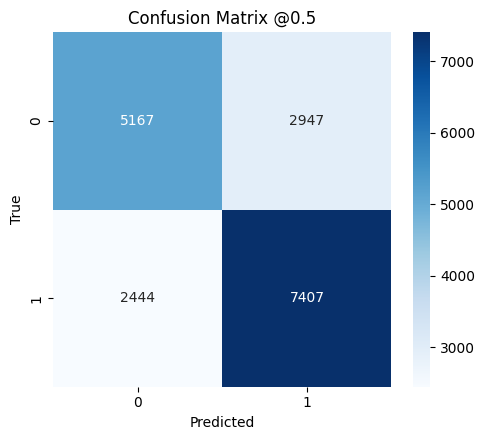

In [5]:
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,average_precision_score, roc_auc_score
)
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 전처리: 수치 = median impute, 범주 = most_frequent + OHE
num_sel = selector(dtype_include=np.number)
cat_sel = selector(dtype_include=['object','category'])

preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        # ("scaler", StandardScaler())  # ← 제거
    ]), num_sel),
    ("cat", Pipeline([
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
    ]), cat_sel)
])

# 모델
model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.07,
    subsample=0.9,
    colsample_bytree=0.9,
    tree_method="hist",
    eval_metric="aucpr",
    random_state=2,
    n_jobs=-1
)

pipe = Pipeline([
    ("pre", preprocess),
    ("model", model)
])

# 학습 
pipe.fit(X_train, y_train)

# 예측 
y_pred_train = pipe.predict(X_train)              
y_pred_test  = pipe.predict(X_test)

# 정확도
print(f"Train Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print(f"Test  Accuracy: {accuracy_score(y_test,  y_pred_test):.4f}")

# 오차행렬/리포트
cm = confusion_matrix(y_test, y_pred_test)
print("\nConfusion Matrix (counts)\n", cm)  
print("\nClassification Report @0.5\n", classification_report(y_test, y_pred_test, digits=4))

# 확률 기반 지표(PR-AUC, ROC-AUC)
y_prob_test = pipe.predict_proba(X_test)[:, 1]
print("Test PR-AUC :", f"{average_precision_score(y_test, y_prob_test):.4f}")
print("Test ROC-AUC:", f"{roc_auc_score(y_test, y_prob_test):.4f}")

# 오차행렬 시각화
plt.figure(figsize=(5,4.5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix @0.5")
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

In [ ]:
pipe.fit(X, y)
feat_names = pipe.named_steps["pre"].get_feature_names_out()
importances = pipe.named_steps["model"].feature_importances_

order = np.argsort(importances)[::-1][:30]
plt.figure(figsize=(7.5,8))
plt.barh(range(len(order)), importances[order][::-1])
plt.yticks(range(len(order)), np.array(feat_names)[order][::-1])
plt.title("XGBoost 피처 중요도 Top 30")
plt.tight_layout(); plt.show() 

In [28]:
# 결측치 처리

In [29]:
# 파생 변수 생성

In [30]:
# 인코딩 

In [31]:
# 최종 피처 선택 (예시)
fnl_col = ['age', 'sex', 'CTPRVN_CODE', 'SPOT_NO', 'mbhld_co', 'reside_adult_co',
       'fma_04z1', 'fma_24z2', 'nue_01z1', 'churn', 'nua_01z2', 'nuc_02z1',
       'nuc_03z1', 'obb_02a1', 'obb_02b1', 'obb_02d1', 'ora_01z1', 'orb_01z1',
       'ord_01d2', 'ord_05z1', 'ord_01f3', 'ore_03z2', 'dra_01z1', 'drb_01z3',
       'drb_03z1', 'drg_01z3', 'pha_04z1', 'pha_07z1', 'phb_01z1', 'pha_11z1',
       'mta_01z1', 'mta_02z1', 'edit_mtc_03z1', 'mtc_08z1', 'mtc_12c1',
       'mtc_12h1', 'mtj_05z2', 'mtj_10z1', 'mtj_11z1', 'smf_01z1',
       'smb_01z1', 'smb_02z1', 'smb_03z1', 'smb_04z1', 'smb_05z1',
       'smb_06z1', 'sma_36z1', 'smb_12z1',
       'sma_08z1', 'sma_11z2',
       'smc_08z2', 'smc_09z2', 'smc_10z2', 'sob_01z1', 'sob_02z1', 'soa_01z1',
       'soa_06z2', 'soa_07z1', 'sod_02z3', 'drb_binge_monthly', 'age_group',
       'is_single', 'fma_14z1_add', 'fma_14z1_log', 'fma_14z1_group',
       'fma_dementia_case']

# ['sma_03z2', 'sma_37z1', 'sma_12z2'] -> 타겟변수 만든 변수
# ['smd_02z3','smd_01z3', 'smb_09z1', 'smb_11z1', 'smb_13z1', 'sma_01z1', ...] 제외 -> 예측하고자 하는 타겟의 정보를 가지고있는 변수
df = df[fnl_col]

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89822 entries, 0 to 89821
Data columns (total 66 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                89822 non-null  float64
 1   sex                89822 non-null  object 
 2   CTPRVN_CODE        89822 non-null  object 
 3   SPOT_NO            89822 non-null  object 
 4   mbhld_co           89822 non-null  float64
 5   reside_adult_co    89822 non-null  float64
 6   fma_04z1           89801 non-null  float64
 7   fma_24z2           1095 non-null   float64
 8   nue_01z1           89800 non-null  float64
 9   churn              89822 non-null  int64  
 10  nua_01z2           89822 non-null  float64
 11  nuc_02z1           89315 non-null  float64
 12  nuc_03z1           19738 non-null  float64
 13  obb_02a1           44065 non-null  float64
 14  obb_02b1           44058 non-null  float64
 15  obb_02d1           44058 non-null  float64
 16  ora_01z1           898

(71857, 65) (71857,) (17965, 65) (17965,) 

Accuracy: 0.9702198719732814
smb_06z1            0.873343
sma_36z1            0.053993
sma_11z2            0.006367
SPOT_NO             0.004656
age                 0.004530
smb_04z1            0.003638
soa_06z2            0.003103
CTPRVN_CODE         0.002968
smb_12z1            0.002792
pha_07z1            0.001884
drb_03z1            0.001804
edit_mtc_03z1       0.001711
mtc_12c1            0.001672
drb_01z3            0.001656
pha_11z1            0.001606
phb_01z1            0.001560
ord_05z1            0.001559
fma_14z1_add        0.001555
smb_03z1            0.001548
reside_adult_co     0.001503
mbhld_co            0.001436
fma_14z1_log        0.001434
sob_01z1            0.001369
orb_01z1            0.001339
pha_04z1            0.001248
drg_01z3            0.001232
ora_01z1            0.001159
smb_05z1            0.001091
nua_01z2            0.001074
mtc_08z1            0.000957
sod_02z3            0.000880
ord_01d2            0.000878

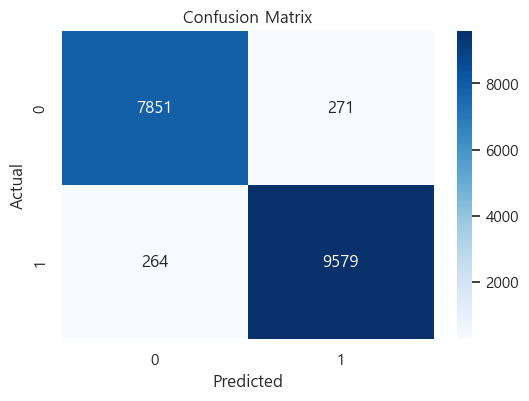

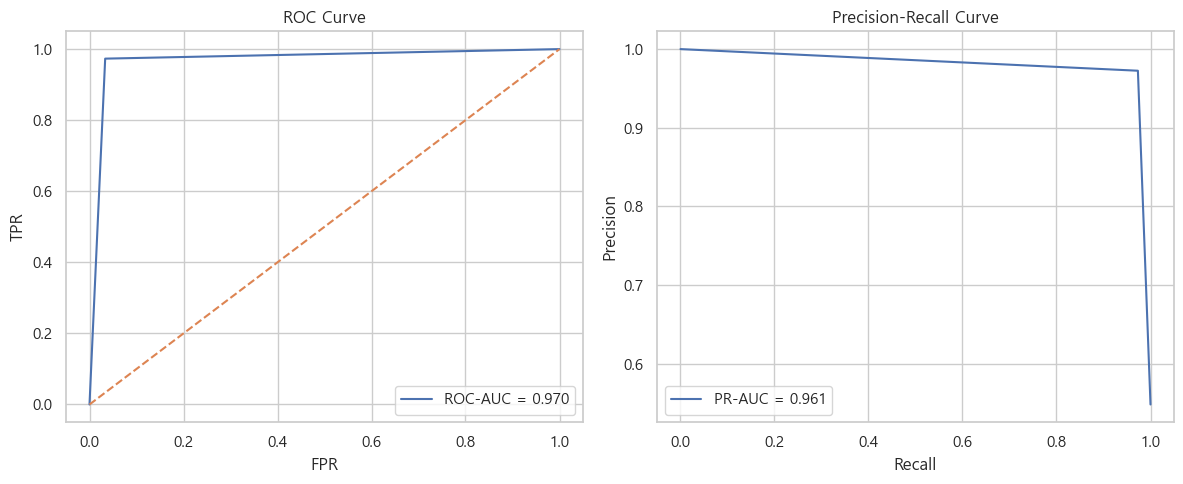

In [33]:
# 모델
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns

# 데이터 분리
X = df.drop('churn', axis=1)
y = df['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape, '\n')

# 모델 학습
model = DecisionTreeClassifier(random_state=2)
model.fit(X_train, y_train)

# 예측 및 평가
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

# 변수중요도
feature_importance = pd.Series(model.feature_importances_, index=X.columns)
print(feature_importance.sort_values(ascending=False), '\n')

# 혼동행렬
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC-AUC
y_prob = model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)

# PR-AUC
pr_auc = average_precision_score(y_test, y_prob)
prec, recall, _ = precision_recall_curve(y_test, y_prob)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(fpr, tpr, label=f"ROC-AUC = {roc_auc:.3f}")
axes[0].plot([0,1],[0,1],'--')
axes[0].set_xlabel("FPR")
axes[0].set_ylabel("TPR")
axes[0].set_title("ROC Curve")
axes[0].legend()

axes[1].plot(recall, prec, label=f"PR-AUC = {pr_auc:.3f}")
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve")
axes[1].legend()

plt.tight_layout()
plt.show()